# UNHCR Refugee Data - Predicting acceptance of refugee / asylee groups

## Abstract

## Introduction

[UNHCR Refugee Data](https://www.kaggle.com/unitednations/refugee-data)  

## Research Questions

<ol>
    <li>What features are common across groups of refugees / asylees with high percentage of acceptance  rates? </li>
    <li>Does country of origin play a role in acceptance rate?</li>
    <li>Does  gender of the asylees / refugees in each group play role? </li>
</ol>


## Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Data Import, Cleaning

In [2]:
path = '/Users/gemma/Documents/data science/DS bootcamp prep/datasets/refugee-data/'

# Data from the UNHCR

asylees = pd.read_csv(path+'asylum_seekers.csv', low_memory=False)
demographics = pd.read_csv(path+'demographics.csv', low_memory=False)

# Data from the IUCN Red List - standardized list of countries and their regions

regions = pd.read_csv(path+'countries_regions_from_iucnredlist.csv')


I will import and clean up each of the three dataframes in order, and then merge them.

### 1. Asylees

In [3]:
asylees.head(3)

,Year,Country / territory of asylum/residence,Origin,RSD procedure type / level,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,Total decisions,Total pending end-year,of which UNHCR-assisted(end-year)
0,2000,Zimbabwe,Afghanistan,G / FI,0,0,5,5,0,0,0,5,0,0
1,2000,South Africa,Afghanistan,G / FI,8,1,0,0,0,0,0,NaN,8,0
2,2000,Uzbekistan,Afghanistan,U / FI,265,265,2156,747,0,112,327,1186,1235,1235


This dataframe has data on asylees' yearly progress through the refugee process. Let's take a look at the amount of data and the types of data that are stored here.

In [4]:
asylees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129720 entries, 0 to 129719
Data columns (total 14 columns):
Year                                       129720 non-null int64
Country / territory of asylum/residence    129720 non-null object
Origin                                     129720 non-null object
RSD procedure type / level                 129719 non-null object
Tota pending start-year                    124578 non-null object
of which UNHCR-assisted(start-year)        118962 non-null object
Applied during year                        126222 non-null object
decisions_recognized                       119886 non-null object
decisions_other                            114974 non-null object
Rejected                                   121615 non-null object
Otherwise closed                           120850 non-null object
Total decisions                            97082 non-null object
Total pending end-year                     125832 non-null object
of which UNHCR-assisted(end-year)

In [5]:
asylees.isnull().sum()

Year                                           0
Country / territory of asylum/residence        0
Origin                                         0
RSD procedure type / level                     1
Tota pending start-year                     5142
of which UNHCR-assisted(start-year)        10758
Applied during year                         3498
decisions_recognized                        9834
decisions_other                            14746
Rejected                                    8105
Otherwise closed                            8870
Total decisions                            32638
Total pending end-year                      3888
of which UNHCR-assisted(end-year)           7837
dtype: int64

In [6]:
asylees.isnull().sum().sum()

105317

It also looks like there is a lot of missing data. Filling the missing data with 0 could create inaccuracies, but excluding records with missing data could also bias the results: Presumably the records with missing data are from groups/locations with the least amount of resources to collect data, so excluding these groups from analysis could further marginalize them.

After considering both of these issues, and this specific dataframe, I decided to drop the rows with missing data because of the sheer size of the dataframe. However, it is a good idea to keep this process in mind when looking at the results.

In [7]:
asylees.dropna(axis=0,how='any', inplace=True)


In [8]:
asylees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85187 entries, 0 to 129709
Data columns (total 14 columns):
Year                                       85187 non-null int64
Country / territory of asylum/residence    85187 non-null object
Origin                                     85187 non-null object
RSD procedure type / level                 85187 non-null object
Tota pending start-year                    85187 non-null object
of which UNHCR-assisted(start-year)        85187 non-null object
Applied during year                        85187 non-null object
decisions_recognized                       85187 non-null object
decisions_other                            85187 non-null object
Rejected                                   85187 non-null object
Otherwise closed                           85187 non-null object
Total decisions                            85187 non-null object
Total pending end-year                     85187 non-null object
of which UNHCR-assisted(end-year)          851

Because all of these columns are stored as objects, including the numeric columns, I am going to convert them to numeric values.

In [9]:
# the ints/floats in the table are stored as strings, need to convert...

colnames = asylees.columns.values
asylees[colnames[4:]] = asylees[colnames[4:]].apply(pd.to_numeric, 
                                                    errors='coerce', axis=1)

# if anything is less than 0 just make it 0, otherwise it will mess up later on
for col in colnames[4:]:
    asylees[col] = asylees[col].apply(lambda x: 0 if x < 0 else x)

I'm also going to add a column to show the percentage accepted and percentage rejected per record.

First, I need to get an accurate number of total asylees / refugees for that year and country, and then divide 'decisions_recognized' and 'rejected' by the resulting number.

To get the total number, I was initially planning on adding up the columns 'Applied during year' and 'Tota pending start-year' to . However, there were some instances where the values under "Applied during year" and "Total pending start-year" were listed as 0 even though the the decisions_recognized or Rejected was greater than 0. (This is probably due to my filling NaN with 0.) See below:

In [10]:
asylees.iloc[48891]

Year                                                           2009
Country / territory of asylum/residence    United States of America
Origin                                                      Romania
RSD procedure type / level                                   G / EO
Tota pending start-year                                          67
of which UNHCR-assisted(start-year)                               0
Applied during year                                              37
decisions_recognized                                             30
decisions_other                                                   0
Rejected                                                         31
Otherwise closed                                                 57
Total decisions                                                 118
Total pending end-year                                           67
of which UNHCR-assisted(end-year)                                 0
Name: 62013, dtype: object

So instead, I chose to add up the columns 'Total decisions' and 'Total pending end-year'.

Then, I'll divide 'decisions_recognized' and 'Rejected' by that result.

In [11]:
asylees.dropna(axis=0,how='any', inplace=True)

asylees.isnull().sum()

Year                                       0
Country / territory of asylum/residence    0
Origin                                     0
RSD procedure type / level                 0
Tota pending start-year                    0
of which UNHCR-assisted(start-year)        0
Applied during year                        0
decisions_recognized                       0
decisions_other                            0
Rejected                                   0
Otherwise closed                           0
Total decisions                            0
Total pending end-year                     0
of which UNHCR-assisted(end-year)          0
dtype: int64

In [12]:
asylees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84459 entries, 0 to 129680
Data columns (total 14 columns):
Year                                       84459 non-null int64
Country / territory of asylum/residence    84459 non-null object
Origin                                     84459 non-null object
RSD procedure type / level                 84459 non-null object
Tota pending start-year                    84459 non-null float64
of which UNHCR-assisted(start-year)        84459 non-null float64
Applied during year                        84459 non-null float64
decisions_recognized                       84459 non-null float64
decisions_other                            84459 non-null float64
Rejected                                   84459 non-null float64
Otherwise closed                           84459 non-null float64
Total decisions                            84459 non-null float64
Total pending end-year                     84459 non-null float64
of which UNHCR-assisted(end-year)    

In [13]:
# getting the total
asylees['Total_to_divide'] = (asylees['Total decisions'] + 
                              asylees['Total pending end-year']).astype(int)

# getting the % recognized (accepted) for each row
asylees['percentage_accepted'] = ((asylees['decisions_recognized']) / 
                                  (asylees['Total_to_divide'])*100).apply(pd.to_numeric, 
                                                                          errors='coerce').fillna(0)

# % rejected
asylees['percentage_rejected'] = ((asylees['Rejected']) / 
                                  (asylees['Total_to_divide'])*100).apply(pd.to_numeric, 
                                                                          errors='coerce').fillna(0)


Taking a look at the distribution overall of acceptance and rejection rates:

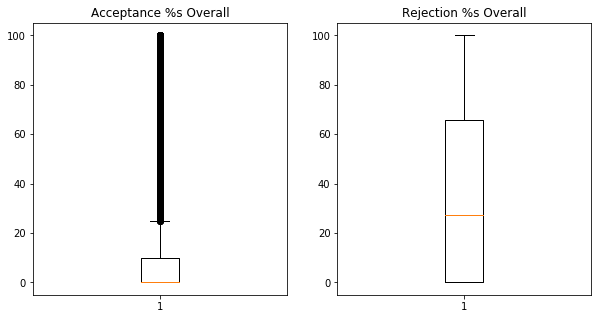

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(asylees['percentage_accepted'])
plt.title('Acceptance %s Overall')


plt.subplot(1,2,2)
plt.boxplot(asylees['percentage_rejected'])
plt.title('Rejection %s Overall')
plt.show()

Let's look at the countries of asylum that accepted the highest percentages, and countries of origin that had the highest acceptance percentages.

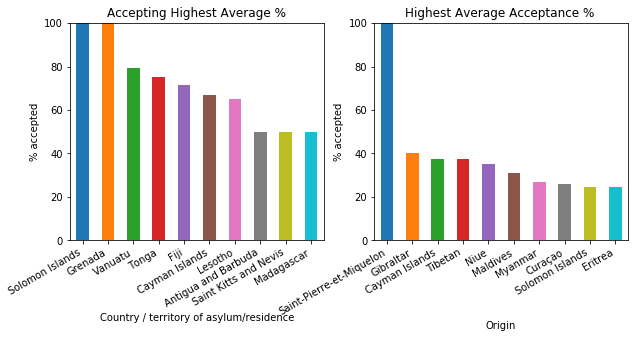

In [15]:
accepted_r = asylees.groupby('Country / territory of asylum/residence')['percentage_accepted'].mean().sort_values(ascending=False)

accepted_origin = asylees.groupby('Origin')['percentage_accepted'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

ax = accepted_r[:10].plot(kind='bar')
ax.set_ylabel('% accepted')
ax.set_ylim([0,100])
ax.set_title('Accepting Highest Average %')
ax.set_xticklabels(accepted_r[:10].index.values)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.subplot(1,2,2)

ax = accepted_origin[:10].plot(kind='bar')
ax.set_ylim([0,100])
ax.set_ylabel('% accepted')
ax.set_title('Highest Average Acceptance % ')
ax.set_xticklabels(accepted_origin[:10].index.values)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()


And let's also look at the countries of asylum that rejected the highest percentages, and countries of origin that had the highest rejection percentages.

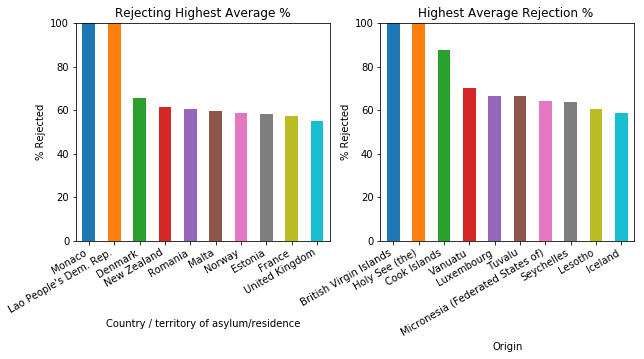

In [16]:
rejected_r = asylees.groupby('Country / territory of asylum/residence')['percentage_rejected'].mean().sort_values(ascending=False)

rejected_origin = asylees.groupby('Origin')['percentage_rejected'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

ax = rejected_r[:10].plot(kind='bar')
ax.set_ylim([0,100])
ax.set_ylabel('% Rejected')
ax.set_title('Rejecting Highest Average %')
ax.set_xticklabels(rejected_r[:10].index.values)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.subplot(1,2,2)

ax = rejected_origin[:10].plot(kind='bar')
ax.set_ylim([0,100])
ax.set_ylabel('% Rejected')
ax.set_title('Highest Average Rejection % ')
ax.set_xticklabels(rejected_origin[:10].index.values)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()


Finally, let's look at the RSD variable, which is referring to the refugee status of the group.

In [17]:
asylees.groupby('RSD procedure type / level')['Year'].count()

RSD procedure type / level
G / AR    12103
G / BL      113
G / CA      216
G / EO     2424
G / FA     5634
G / FI    41440
G / IN     2237
G / JR     1299
G / NA     1912
G / RA     2427
G / SP      296
G / TA      251
G / TP      120
G / TR       12
G / ar       41
G / fi       50
J / AR       18
J / FA      282
J / FI      451
J / RA        3
U / AR     2049
U / FA     2135
U / FI     8466
U / JR        4
U / RA      476
Name: Year, dtype: int64

It looks like these might be mistakes that need to be replaced: 

*  G / ar       41
*  G / fi       50

In [18]:
asylees.replace(to_replace=['G / ar', 'G / fi'] , value=['G / AR', 'G / FI'], inplace=True)

In [19]:
binarized_a = pd.get_dummies(asylees['RSD procedure type / level'])

# join the dummies back up with the countries names

asylees2 = pd.concat([asylees.drop('RSD procedure type / level',1), binarized_a], 
                     axis=1, join_axes=[asylees.index])

In [20]:
asylees2.head()

,Year,Country / territory of asylum/residence,Origin,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,...,G / TR,J / AR,J / FA,J / FI,J / RA,U / AR,U / FA,U / FI,U / JR,U / RA
0,2000,Zimbabwe,Afghanistan,0.0,0.0,5.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2000,Uzbekistan,Afghanistan,265.0,265.0,2156.0,747.0,0.0,112.0,327.0,...,0,0,0,0,0,0,0,1,0,0
3,2000,United States of America,Afghanistan,196.0,0.0,225.0,151.0,0.0,31.0,68.0,...,0,0,0,0,0,0,0,0,0,0
4,2000,United States of America,Afghanistan,193.0,0.0,218.0,182.0,0.0,51.0,40.0,...,0,0,0,0,0,0,0,0,0,0
5,2000,Ukraine,Afghanistan,40.0,0.0,662.0,275.0,0.0,412.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### 2. Demographics

Let's take a look at the second dataframe, demographics:

In [21]:
demographics.head()

,Year,Country / territory of asylum/residence,Location Name,Female 0-4,Female 5-11,Female 5-17,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,Male 5-11,Male 5-17,Male 12-17,Male 18-59,Male 60+,M: Unknown,M: Total
0,2001,Afghanistan,Kabul,0,NaN,1.0,NaN,1,0,0.0,2,0,NaN,0.0,NaN,2,0,0.0,2
1,2001,Afghanistan,Various,14335,NaN,45451.0,NaN,99880,19234,412004.0,590904,14716,NaN,47522.0,NaN,114965,13025,435492.0,625720
2,2001,Afghanistan,Herat,0,NaN,0.0,NaN,1,0,0.0,1,0,NaN,0.0,NaN,1,0,0.0,1
3,2001,Angola,Viana,484,NaN,1687.0,NaN,1282,43,0.0,3496,597,NaN,1645.0,NaN,787,34,0.0,3063
4,2001,Angola,Moxico,219,NaN,734.0,NaN,427,25,0.0,1405,226,NaN,711.0,NaN,139,15,0.0,1091


In [22]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18356 entries, 0 to 18355
Data columns (total 19 columns):
Year                                       18356 non-null int64
Country / territory of asylum/residence    18356 non-null object
Location Name                              18355 non-null object
Female 0-4                                 17083 non-null object
Female 5-11                                13927 non-null object
Female 5-17                                3196 non-null float64
Female 12-17                               13949 non-null object
Female 18-59                               17694 non-null object
Female 60+                                 16900 non-null object
F: Unknown                                 12493 non-null float64
F: Total                                   18356 non-null object
Male 0-4                                   17075 non-null object
Male 5-11                                  13950 non-null object
Male 5-17                                  319

It also looks like there is quite a bit of missing data here.

In [23]:
demographics.isnull().sum()

Year                                           0
Country / territory of asylum/residence        0
Location Name                                  1
Female 0-4                                  1273
Female 5-11                                 4429
Female 5-17                                15160
Female 12-17                                4407
Female 18-59                                 662
Female 60+                                  1456
F: Unknown                                  5863
F: Total                                       0
Male 0-4                                    1281
Male 5-11                                   4406
Male 5-17                                  15160
Male 12-17                                  4370
Male 18-59                                   436
Male 60+                                    1370
M: Unknown                                  5856
M: Total                                       0
dtype: int64

This dataframe is significantly smaller than the previous one, so just dropping all records with missing data could skew the data and resulting conclusions, in the way that I discussed above.

It looks like the columns Male 5-17 and Female 5-17 each have 15160 null values. Since the dataframe's length is 18356, that means each of those columns is missing 83% of the data. Since the data is already for the most part present in F and M 5 - 11 and F and M 12 - 17, let's drop the two 5 - 17 columns.


In [24]:
demographics = demographics.drop(['Female 5-17','Male 5-17'],1)

Now let's see how much data is still missing, and specifically if the missing data is spread across all of the countries of asylum, or if it is mostly from certain areas.

In [25]:
# put all rows with any NaNs in a separate dataframe
withna = demographics[demographics.isnull().any(axis=1)]

# count up # of records by country
na_count = withna.groupby('Country / territory of asylum/residence', 
                          as_index=False)['Year'].count()

# back to the original dataframe, count all records per country
full_count = demographics.groupby('Country / territory of asylum/residence', 
                                  as_index=False)['Year'].count()

# merge the two to compare in 1 dataframe
counts = pd.merge(na_count.rename(index=str, columns={"Year": "na_count"}), 
                  full_count.rename(index=str, columns={"Year": "full_count"}),
                   on=['Country / territory of asylum/residence'])

# calc the % missing
counts['percent_na'] = counts['na_count'] / counts['full_count']

# view the ones with the highest % of missing data
counts.sort_values('percent_na', ascending=False).head()


,Country / territory of asylum/residence,na_count,full_count,percent_na
136,Seychelles,1,1,1.000000
98,Mauritius,1,1,1.000000
32,Chile,9,10,0.900000
104,Morocco,52,60,0.866667
141,Slovenia,63,77,0.818182


If we drop NaNs, we'll lose all of the data for 2 countries of residence, and a huge percentage of the data for other countries. It looks like most of the NaNs are due to the switch from classifying ages as 5-11 and 12-17 versus 5-17, which was already dropped - see the example below. So it might be best in this case to fill the data with 0s so as to keep the country in the dataframe, and just keep in mind that 0 in those columns might represent missing data. 

In [26]:
demographics.iloc[136]

Year                                                      2001
Country / territory of asylum/residence               Ethiopia
Location Name                              Jijiga (Kebribeyah)
Female 0-4                                                 402
Female 5-11                                                NaN
Female 12-17                                               NaN
Female 18-59                                              2988
Female 60+                                                 102
F: Unknown                                                   0
F: Total                                                  6170
Male 0-4                                                   422
Male 5-11                                                  NaN
Male 12-17                                                 NaN
Male 18-59                                                2332
Male 60+                                                    80
M: Unknown                                             

In [27]:
demographics.replace(to_replace='*', value=0, inplace=True)

demographics = demographics.fillna(0)

In [28]:
demographics.isin(['*']).sum()

Year                                       0
Country / territory of asylum/residence    0
Location Name                              0
Female 0-4                                 0
Female 5-11                                0
Female 12-17                               0
Female 18-59                               0
Female 60+                                 0
F: Unknown                                 0
F: Total                                   0
Male 0-4                                   0
Male 5-11                                  0
Male 12-17                                 0
Male 18-59                                 0
Male 60+                                   0
M: Unknown                                 0
M: Total                                   0
dtype: int64

The columns that have numeric values stored as strings will need to be converted to numeric values.

In [29]:
colnames = demographics.columns.values
 
demographics[colnames[3:]] = demographics[colnames[3:]].apply(pd.to_numeric, 
                                                              errors='coerce', axis=1)
for col in colnames[3:]:
    demographics[col] = demographics[col].apply(lambda x: 0 if 
                                                (isinstance(x,float) and x < 0) else int(x))

In [30]:
demographics['F: Total'].nunique()

5404

Taking a look at the overall distribution of total number of female and males across all records.

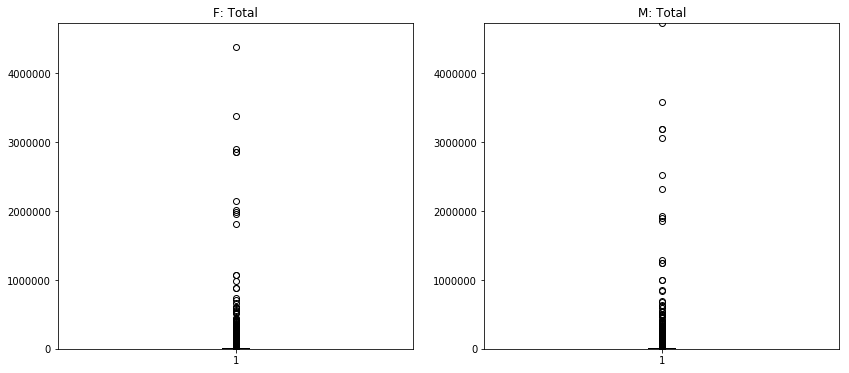

In [31]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.boxplot(demographics['F: Total'])
plt.title('F: Total')
plt.ylim([0,4737475])

plt.subplot(1,2,2)
plt.boxplot(demographics['M: Total'])
plt.title('M: Total')
plt.ylim([0,4737475])

plt.show()

Let's take a look at the distribution among each age range, dropping all 0s because the amount of 0s is so much greater than any other value, and becasue we filled missing data with 0s before.

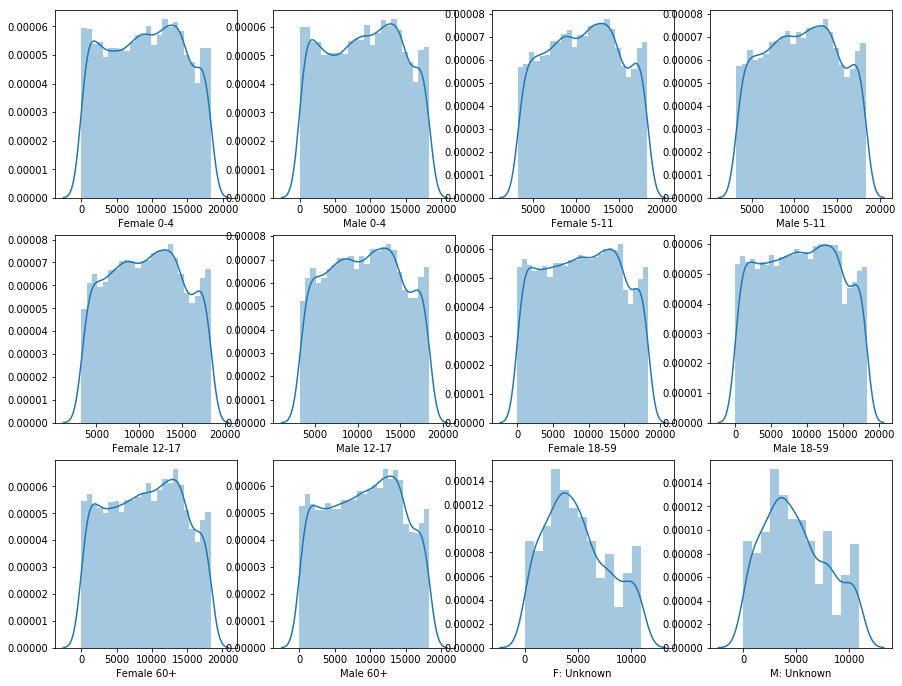

In [32]:
g = plt.figure(figsize=(15,20))
i = 1
 
for col_f, col_m in zip(demographics.columns[3:9], demographics.columns[10:]):
    plt.subplot(5,4,i)
    sns.distplot(demographics[col_f].nonzero())
    plt.xlabel(col_f)
    
    i+=1
    
    plt.subplot(5,4,i)
    sns.distplot(demographics[col_m].nonzero())
    plt.xlabel(col_m)
    i+=1
    

### 3. Regions

Finally, I'll look at the regions dataframe, and after merging the other two together, use this dataframe to binarize the Region of origin and Region of residence.

In [33]:
regions.describe()

,Country,Region
count,258,258
unique,258,13
top,Mali,Europe
freq,1,54


The data in this dataframe is from the [IUCN redlist](http://www.iucnredlist.org/technical-documents/data-organization/countries-by-regions), which follows the ISO 3166 list of countries maintained by the International Organization of Standardization, and assigned them to each geographical region.

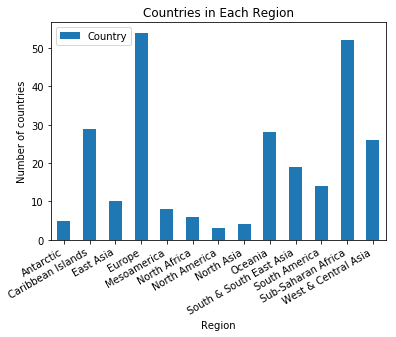

In [34]:
plt.figure(figsize=(4,6))
ax = regions.groupby('Region').count().plot(kind='bar')
plt.ylabel('Number of countries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Countries in Each Region')
plt.show()

### Merging and binarizing

In [36]:
# binarize the region names (get dummies)

binarized = pd.get_dummies(regions['Region'])

# join the dummies back up with the countries names

regions2 = pd.concat([regions, binarized], axis=1, join_axes=[regions.index])

# merge the binarized columns along the 'Country of residence' with the asylees dataframe

reg_res = pd.merge(asylees2, regions2.rename(index=str, 
                                             columns={"Country": 
                                                      "Country / territory of asylum/residence"}).drop('Region',1), 
                    on=['Country / territory of asylum/residence'])

In [37]:
# make a dictionary of the current regions names to a new name, specifying that it is the Region of residence
# and for next one, Region of Origin

all_regions = list(regions['Region'].unique())

region_of_res = {}
region_of_ori = {}

for region in all_regions:
    region_of_res[region] = "Res: " + str(region)
    region_of_ori[region] = "Ori: " + str(region)

# rename relevant columns

reg_res = reg_res.rename(index=str, columns=region_of_res)

In [38]:
# Now the same proecss with Region of Origin

# merge

reg_res2 = pd.merge(reg_res, regions2.rename(index=str, columns={"Country": "Origin"}).drop('Region',1), on=['Origin'])

# and rename

reg_res2 = reg_res2.rename(index=str, columns=region_of_ori)

In [39]:
reg_res2.head()

,Year,Country / territory of asylum/residence,Origin,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,decisions_recognized,decisions_other,Rejected,Otherwise closed,...,Ori: Europe,Ori: Mesoamerica,Ori: North Africa,Ori: North America,Ori: North Asia,Ori: Oceania,Ori: South & South East Asia,Ori: South America,Ori: Sub-Saharan Africa,Ori: West & Central Asia
0,2000,Zimbabwe,Afghanistan,0.0,0.0,5.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,2000,Uzbekistan,Afghanistan,265.0,265.0,2156.0,747.0,0.0,112.0,327.0,...,0,0,0,0,0,0,0,0,0,1
2,2001,Uzbekistan,Afghanistan,1235.0,1235.0,2090.0,1573.0,0.0,247.0,189.0,...,0,0,0,0,0,0,0,0,0,1
3,2002,Uzbekistan,Afghanistan,1316.0,1316.0,516.0,544.0,0.0,22.0,206.0,...,0,0,0,0,0,0,0,0,0,1
4,2003,Uzbekistan,Afghanistan,1060.0,1060.0,378.0,150.0,0.0,218.0,142.0,...,0,0,0,0,0,0,0,0,0,1


Now, I'll merge the dataframe I just created (from Regions and Asylees) with Demographics, dropping unnecessary columns.

In [40]:
asydemo = pd.merge(demographics.drop(['Location Name'], axis=1), reg_res2, 
                   on=['Country / territory of asylum/residence', 
                                    'Year',])

In [41]:
asydemo.head()

,Year,Country / territory of asylum/residence,Female 0-4,Female 5-11,Female 12-17,Female 18-59,Female 60+,F: Unknown,F: Total,Male 0-4,...,Ori: Europe,Ori: Mesoamerica,Ori: North Africa,Ori: North America,Ori: North Asia,Ori: Oceania,Ori: South & South East Asia,Ori: South America,Ori: Sub-Saharan Africa,Ori: West & Central Asia
0,2001,Afghanistan,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1
1,2001,Afghanistan,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1
2,2001,Afghanistan,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1
3,2001,Afghanistan,14335,0,0,99880,19234,412004,590904,14716,...,0,0,0,0,0,0,0,0,0,1
4,2001,Afghanistan,14335,0,0,99880,19234,412004,590904,14716,...,0,0,0,0,0,0,0,0,0,1


## Exploratory Data Analysis

Let's take a look at the correlation between some of the columns and the percentage accepted, which is what we are looking to predict.

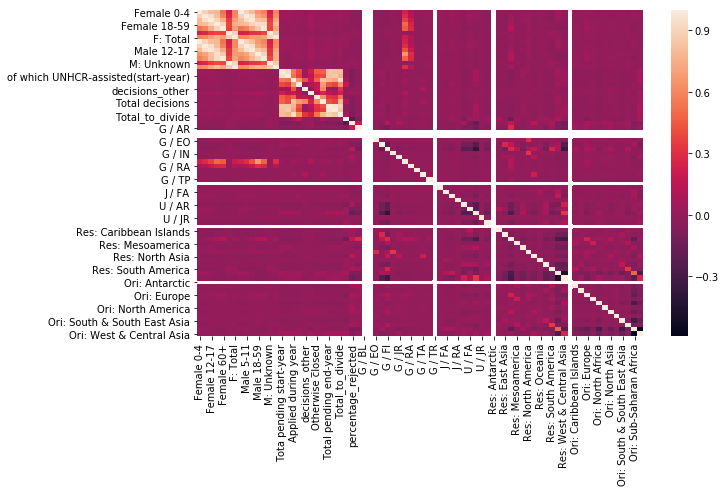

In [42]:
plt.figure(figsize=(10,6))
corr_cols = asydemo.columns[2:].tolist()
corr_mat = asydemo.loc[:, corr_cols].corr()
sns.heatmap(corr_mat)
plt.show()

## Feature Selection and Engineering

While importing the dataframes and merging them, some light feature engineering was completed: creating the features "percentage_accepted" and rejected, getting the region of origin and region of residence, and binarizing those two features.

In [43]:
## do more for hte OLS model

In [44]:
asydemo.columns.values

array(['Year', 'Country / territory of asylum/residence', 'Female 0-4',
       'Female 5-11', 'Female 12-17', 'Female 18-59', 'Female 60+',
       'F: Unknown', 'F: Total', 'Male 0-4', 'Male 5-11', 'Male 12-17',
       'Male 18-59', 'Male 60+', 'M: Unknown', 'M: Total', 'Origin',
       'Tota pending start-year', 'of which UNHCR-assisted(start-year)',
       'Applied during year', 'decisions_recognized', 'decisions_other',
       'Rejected', 'Otherwise closed', 'Total decisions',
       'Total pending end-year', 'of which UNHCR-assisted(end-year)',
       'Total_to_divide', 'percentage_accepted', 'percentage_rejected',
       'G / AR', 'G / BL', 'G / CA', 'G / EO', 'G / FA', 'G / FI',
       'G / IN', 'G / JR', 'G / NA', 'G / RA', 'G / SP', 'G / TA',
       'G / TP', 'G / TR', 'J / AR', 'J / FA', 'J / FI', 'J / RA',
       'U / AR', 'U / FA', 'U / FI', 'U / JR', 'U / RA', 'Res: Antarctic',
       'Res: Caribbean Islands', 'Res: East Asia', 'Res: Europe',
       'Res: Mesoamerica', 'Res

I'm going to drop the columns that were used in creating the percentage_accepted and percentage_rejected in order to avoid duplicating the data. I'm also going to drop the categorical data because it has already been binarized, and so is also redudant. The RSD procedure type / level has already been dropped.

In [46]:
redundant = ['Total decisions', 'Total pending end-year', 'Total_to_divide', 
           'decisions_recognized','Rejected', 'Country / territory of asylum/residence', 
                                                      'Origin']

features = asydemo.drop(redundant, axis=1)


In [47]:
features.columns.values[21]

'percentage_accepted'

In [48]:
#Using KBest to select the features that will add the most predictive power to the model.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Create an SelectKBest object to select features with k best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k=25)

coltitles = features.columns.values

# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(features, features['percentage_accepted'])

print('Original number of features:', features.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [24 25 36 46 59] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Original number of features: 72
Reduced number of features: 25


In [49]:
idxs_selected = fvalue_selector.get_support(indices=True)

# add percentage_accepted back in
idxs_selected = np.append(idxs_selected, [21])

print(idxs_selected)


[ 0 11 15 16 17 19 20 26 27 28 29 31 37 38 39 41 42 43 51 52 55 57 58 70
 71 21]


In [50]:
features_new = features.loc[:,coltitles[idxs_selected]]

features_new.head()

,Year,Male 18-59,Tota pending start-year,of which UNHCR-assisted(start-year),Applied during year,Otherwise closed,of which UNHCR-assisted(end-year),G / EO,G / FA,G / FI,...,U / FA,U / FI,Res: North Africa,Res: North America,Res: South & South East Asia,Res: Sub-Saharan Africa,Res: West & Central Asia,Ori: Sub-Saharan Africa,Ori: West & Central Asia,percentage_accepted
0,2001,2,0.0,0.0,15.0,5.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,1,20.000000
1,2001,2,0.0,0.0,6.0,0.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,1,0.000000
2,2001,2,0.0,0.0,110.0,21.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,1,19.090909
3,2001,114965,0.0,0.0,15.0,5.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,1,20.000000
4,2001,114965,0.0,0.0,6.0,0.0,0.0,0,0,0,...,0,1,0,0,0,0,1,0,1,0.000000


In [51]:
features_new['percentage_accepted'] = features_new['percentage_accepted'].apply(lambda 
                                        x: int(x))


The dataset is large and runs slowly on my computer, so I'm going to split the data with Stratified KFold.

In [52]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)

In [53]:
X = features_new.drop(['percentage_accepted'],1)
y = features_new['percentage_accepted']

skf.get_n_splits(X, y)

10

In [54]:
for train_index, test_index in skf.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


## Models

### OLS (Ordinary Least Squares)

In [79]:
import statsmodels.api as sm
from sklearn import linear_model
import statsmodels.formula.api as smf

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


On the smaller, features dataframe:

In [86]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)



Coefficients: 
 [-9.02619730e-02 -6.60721819e-07  3.96305582e-04  3.96923411e-03
  4.98622181e-03 -6.10106490e-03 -5.72140797e-03  1.35445587e-14
  2.46619232e+00  8.44736509e-01 -2.46523572e-14 -5.54659925e+00
 -1.06743108e+01 -1.17902362e+00  4.80394636e+00 -5.97871895e+00
  1.18111962e+00  7.57470482e-01  5.24172562e+00  7.34981456e+00
  8.45253322e+00  9.22075258e+00  5.91824906e+00 -3.39361622e-01
  5.69955907e+00]

Intercept: 
 187.3161591680747

R-squared:
-0.16127902498249025


With the full dataframe

In [87]:
regr = linear_model.LinearRegression()

regr.fit(X_train2, y_train2)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test2, y_test2))


Coefficients: 
 [-2.67757765e-01  3.45676488e-04  1.23336497e-03  1.03817321e-03
  9.96879476e-04 -4.15809913e-04  6.71186715e-04 -8.25234642e-04
 -6.02345827e-05 -1.07989608e-03 -1.07562352e-03 -8.23498576e-04
  5.92421867e-04 -5.32904904e-04  6.90349718e-04 -1.12272595e-03
  4.11938972e-03  3.87272748e-03 -4.06527436e-03 -4.25677823e-03
 -4.40888704e-03 -1.96226472e-01  4.54965471e+00 -1.61382629e-14
 -2.17590689e-14 -8.30071092e+00  2.36138690e+00  3.64536346e+00
 -6.49039006e+00  1.32316095e+01  1.45385236e+01  1.14610248e+01
  5.46064203e-01  2.16880412e+00 -6.60481269e+00  1.37865381e-14
 -1.38748949e+01 -2.92628261e+00  4.96016690e+00 -4.07851895e+00
 -2.69881409e+00 -3.45164588e-01  1.10655080e+00 -1.77016322e+01
  4.45207199e+00  8.65185943e-15  2.00563248e+01 -5.95190822e+00
 -1.33275537e+01  8.00000959e-02 -4.33591287e+00 -1.19274112e+00
 -1.10865201e+01  2.75913223e+01 -7.82677318e-01 -3.71503835e+00
 -1.07193776e+00 -6.26335769e+00 -5.17150745e-15 -7.13759934e-02
 -1.8712

### Ridge Regression

on the features dataframe

In [80]:
from sklearn import linear_model

ridgeregr = linear_model.Ridge(alpha=16, fit_intercept=False) 
ridgeregr.fit(X_train, y_train)
print(ridgeregr.score(X_test, y_test))
origparams = ridgeregr.coef_[0]
print(origparams)

-0.16086743474348508
0.0028818314408473665


on the full dataframe

In [89]:
ridgeregr.fit(X_train2, y_train2)
print(ridgeregr.score(X_test2, y_test2))
origparams = ridgeregr.coef_[0]
print(origparams)

0.13023252757327652
0.007606526169392746


### Random Forest

In [57]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

I was unable to run randomized search to get the best parameters for the random forest regressor model because it never could complete running / took too long.

on the test and training samples from features_new (24 selected features)

In [61]:
rfc = ensemble.RandomForestRegressor(n_estimators=200, criterion='mse', 
    #                                  max_depth=None, max_features=2,
    #                        min_samples_leaf=8, min_samples_split=6
                                    )

start = time()

rfc.fit(X_train, y_train)

y_true, y_pred = y_test, rfc.predict(X_test)

print(rfc.score(X_test, y_test))

duration = ((time() - start))

0.3026159962023428


In [64]:
print("Random Forest took %.2f seconds"
      "  settings." % (duration))

Random Forest took 275.11 seconds  settings.


In [77]:
scores = cross_val_score(rfc, X_test, y_test, cv=10)

print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[-1.06789118  0.997959    0.99550301  0.99989433  0.85955086  0.65173471
  0.17540351  0.74525089  0.37586355 -0.80226194]
Accuracy: 0.39 (+/- 1.43)


on the Stratified kfold from the original / full dataframe

In [66]:
start = time()

rfc.fit(X_train2, y_train2)

y_true, y_pred = y_test2, rfc.predict(X_test2)

print(rfc.score(X_test2, y_test2))
print("Random Forest took %.2f seconds"
      "  settings." % ((time() - start)))

0.980070504146224
Random Forest took 786.64 seconds  settings.


In [67]:
scores_full = cross_val_score(rfc, X_train2, y_train2, cv=10)

In [68]:
print(scores_full)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores_full.mean(), scores_full.std() * 2))

[0.9771744  0.97588584 0.97883973 0.98050523 0.97937777 0.97699924
 0.9775221  0.97585904 0.97768179 0.97777088]
Accuracy: 0.98 (+/- 0.00)


In [76]:
scores_full2 = cross_val_score(rfc, X_test2, y_test2, cv=10)

print(scores_full2)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores_full2.mean(), scores_full2.std() * 2))

[0.94502189 0.94689713 0.94834007 0.94389489 0.93251091 0.94327573
 0.9545977  0.95279826 0.94680048 0.94276628]
Accuracy: 0.95 (+/- 0.01)


In [84]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

Feature ranking:


In [82]:
name_of_cols = X_test2.columns.values

for f in range(X.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, 
                                        indices[f], names_of_cols[int(indices[f])],
                                        importances[indices[f]]))

1. feature 21 - percentage_rejected (0.393803)
2. feature 20 - of which UNHCR-assisted(end-year) (0.169164)
3. feature 19 - Otherwise closed (0.114424)
4. feature 17 - Applied during year (0.082327)
5. feature 18 - decisions_other (0.056633)
6. feature 15 - Tota pending start-year (0.038374)
7. feature 16 - of which UNHCR-assisted(start-year) (0.035025)
8. feature 0 - Year (0.025819)
9. feature 41 - U / FA (0.005561)
10. feature 56 - Res: Sub-Saharan Africa (0.005198)
11. feature 48 - Res: Europe (0.005036)
12. feature 42 - U / FI (0.004777)
13. feature 57 - Res: West & Central Asia (0.004444)
14. feature 70 - Ori: West & Central Asia (0.004363)
15. feature 27 - G / FI (0.003823)
16. feature 54 - Res: South & South East Asia (0.003315)
17. feature 26 - G / FA (0.003170)
18. feature 44 - U / RA (0.002886)
19. feature 69 - Ori: Sub-Saharan Africa (0.002731)
20. feature 55 - Res: South America (0.002727)
21. feature 47 - Res: East Asia (0.002282)
22. feature 11 - Male 18-59 (0.002044)
23.

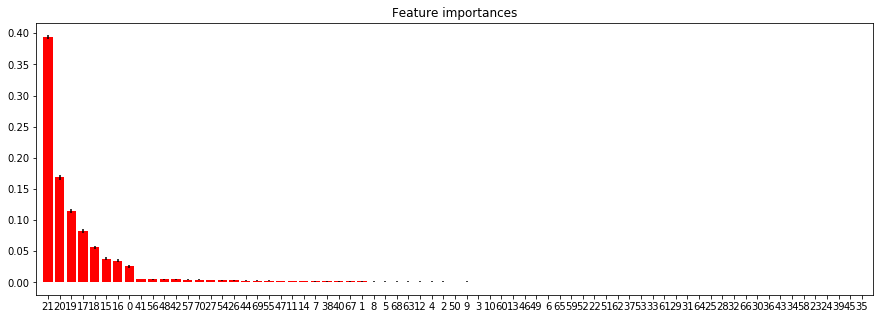

In [83]:
# Plot the feature importances of the forest
plt.figure(figsize=[15,5])
plt.title("Feature importances")
plt.bar(range(X_train2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train2.shape[1]), indices)
plt.xlim([-1, X_train2.shape[1]])
plt.show()

## KNN Regression

In [69]:
from sklearn import neighbors

In [70]:
from sklearn.preprocessing import MinMaxScaler

data = features_new.drop('percentage_accepted',1)
scaler = MinMaxScaler()
print(scaler.fit(data))
MinMaxScaler(copy=True, feature_range=(0, 17))
print(scaler.data_max_)
scaled = pd.DataFrame(scaler.transform(data))

MinMaxScaler(copy=True, feature_range=(0, 1))
[2.016000e+03 1.047938e+06 4.246900e+04 4.246900e+04 2.654480e+05
 2.680200e+04 5.445700e+04 1.000000e+00 1.000000e+00 1.000000e+00
 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00]


In [71]:
renaming = {}

orig = features_new.columns.values
wrong = scaled.columns.values
for yes,no in zip(orig,wrong):
    renaming[no] = yes
    
scaled = scaled.rename(mapper=renaming, axis=1)

In [72]:
X3 = scaled
Y3 = features_new['percentage_accepted']

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X3, Y3, test_size=0.5, random_state=0)

#### Unweighted

In [ ]:
for i in range(13,34,4):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
   
    knn.fit(X_train3, y_train3)

    y_true, y_pred = y_test3, knn_w.predict(X_test3)

    print('For {} neighbors: '.format(i))
    print(knn_w.score(X_test3, y_test3))

For 13 neighbors: 
0.5950199393533111
For 17 neighbors: 
0.5950199393533111
For 21 neighbors: 
0.5950199393533111
For 25 neighbors: 
0.5950199393533111
For 29 neighbors: 
0.5950199393533111
For 33 neighbors: 


In [73]:
# i want to try out 1 more
knn = neighbors.KNeighborsRegressor(n_neighbors=18)

start = time()
knn.fit(X_train3, y_train3)

y_true, y_pred = y_test3, knn.predict(X_test3)

print('For {} neighbors: '.format('18'))
print(knn.score(X_test3, y_test3))
print("KNN unweighted took %.2f seconds ." % ((time() - start)))

For 18 neighbors: 
0.5019361356885168
KNN unweighted took 816.44 seconds .


#### Weighted

In [ ]:
for i in range(13,34,4):
    knn_w = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    
    knn_w.fit(X_train3, y_train3)

    y_true, y_pred = y_test3, knn_w.predict(X_test3)

    print('For {} neighbors: '.format(i))
    print(knn_w.score(X_test3, y_test3))

In [74]:
# trying one more

knn_w = neighbors.KNeighborsRegressor(n_neighbors=27, weights='distance')

start = time()
knn_w.fit(X_train3, y_train3)

y_true, y_pred = y_test3, knn_w.predict(X_test3)

print('For {} neighbors: '.format('27'))
print(knn_w.score(X_test3, y_test3))

print("KNN weighted took %.2f seconds ." % ((time() - start)))

For 27 neighbors: 
0.5950199393533111
KNN weighted took 893.72 seconds .


In [75]:
score = cross_val_score(knn, X_train3, y_train3, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X_train3, y_train3, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.47 (+/- 0.01)
Weighted Accuracy: 0.57 (+/- 0.01)


In [ ]:
# do the variable importance plot for this

## Conclusion

Initially, I wanted to find out if there were common features among groups of refugees / asylees that were accepted in large percentgae, and specifically I wanted to look at country of origin and residence, as well as the gender breakdown of each group. After analyzing the data and using 4 different models, all of which resulted in very low accuracy, it appears that the percentage of acceptance of each group can not be accurately predicted based on the features that I had tested. There doesn't appear to be distinguishing traits in the dataset for high acceptance percentages. This would suggest that there is more information needed to make an accurate and meaningful predictive model. 

In [ ]:
# updae the conclusion to reflect the 60% correct on KNN, look at its variable importance plot
# and amke a comment on the top 5 or 10 variables
